# Module 2: Problem Solving, Search, and Constraint Satisfaction

**CS 440: Artificial Intelligence**

## Overview
In this module, we explore how AI agents can solve complex problems through search and constraint satisfaction. We'll cover:
- State-space graphs and abstraction
- Uninformed search (BFS, DFS)
- Informed search (A* algorithm)
- Evaluation functions and heuristics
- Asymptotic complexity (Big-O notation)
- Constraint Satisfaction Problems (CSPs)
- Backtracking search and arc consistency (AC-3)
- Local search (min-conflicts)

## Drone Throughline
Our mining drone's mission expands to a **vast, known, deterministic asteroid field** where resources are far apart and navigation is costly. The drone must:
1. Use **A* search** with admissible heuristics to find optimal paths through the asteroid field
2. Manage a **daily schedule** as a CSP with variables like "Drill Time" and "Fuel Usage" that must satisfy operational constraints
3. Apply **backtracking search** and **arc consistency (AC-3)** to ensure legal operations
4. Use **min-conflicts** to quickly repair schedules when new tasks are added

In [9]:
# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from typing import List, Tuple, Dict, Any, Set, Optional
import random
from enum import Enum
from collections import deque
import heapq
import time

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. State-Space Graphs and Abstraction

### What is a State Space?
A **state space** is the set of all possible states that can be reached from an initial state by a sequence of actions.

**Key Concepts:**
- **State**: A configuration of the world at a particular moment
- **Initial State**: Where the agent starts
- **Goal State**: The desired destination or configuration
- **Actions**: Operations that transition between states
- **Path Cost**: The cumulative cost of a sequence of actions

### Abstraction
**Abstraction** removes unnecessary details to make the problem tractable. For the asteroid field:
- **States**: Grid coordinates (x, y)
- **Actions**: Move North, South, East, West
- **Abstracted away**: Exact drone orientation, fuel chemistry, engine temperature, etc.

### State-Space Graph
A directed graph where:
- **Nodes** = States
- **Edges** = Actions (transitions)
- **Edge weights** = Action costs

$$\text{Goal: Find the lowest-cost path from initial state to goal state}$$

Asteroid field created: 15x15
Resources at: {(11, 1), (4, 3), (10, 1), (3, 2), (0, 11)}


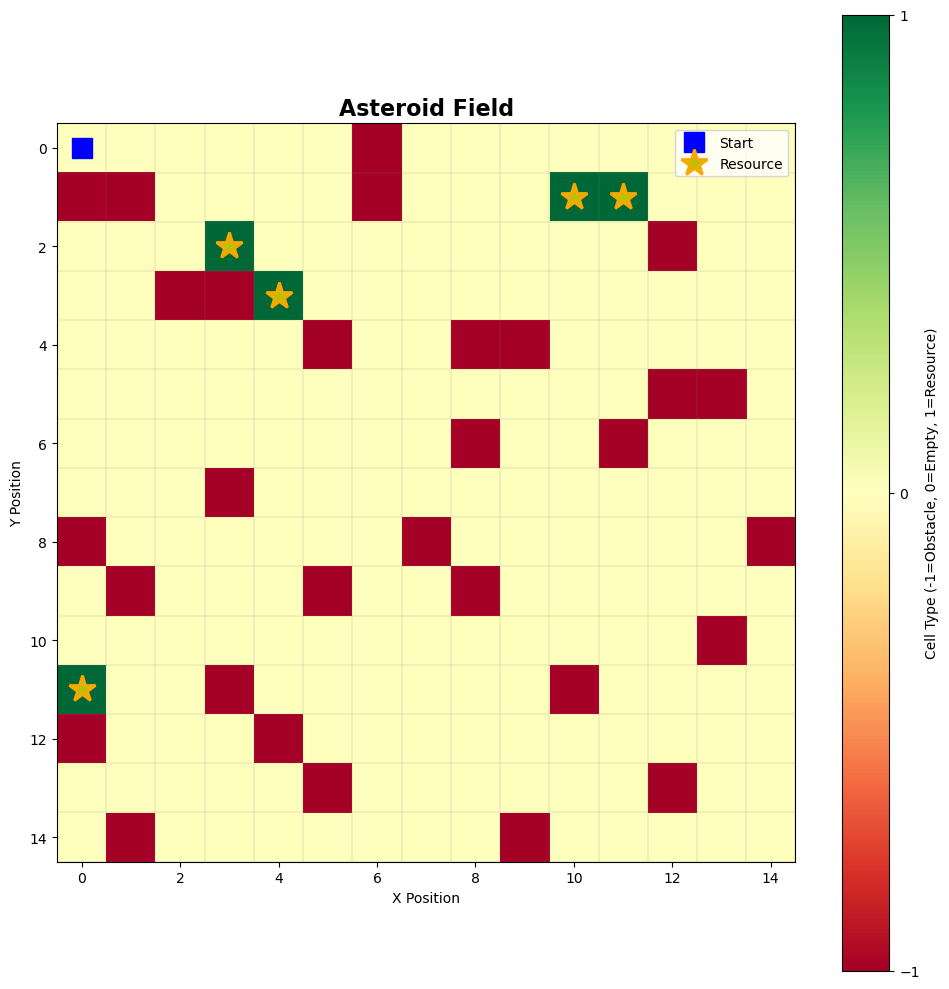

In [10]:
# Create the asteroid field environment

class AsteroidField:
    """Vast asteroid field with sparse resources."""
    
    def __init__(self, width: int = 15, height: int = 15, num_resources: int = 5, num_obstacles: int = 20):
        """
        Initialize asteroid field.
        
        Args:
            width: Field width
            height: Field height
            num_resources: Number of resource locations
            num_obstacles: Number of impassable asteroids
        """
        self.width = width
        self.height = height
        self.grid = np.zeros((height, width), dtype=int)
        # 0 = empty space, 1 = resource, -1 = obstacle
        
        # Place resources
        self.resources = set()
        while len(self.resources) < num_resources:
            x, y = random.randint(0, width-1), random.randint(0, height-1)
            if (x, y) not in self.resources:
                self.resources.add((x, y))
                self.grid[y][x] = 1
        
        # Place obstacles
        self.obstacles = set()
        while len(self.obstacles) < num_obstacles:
            x, y = random.randint(0, width-1), random.randint(0, height-1)
            if (x, y) not in self.resources and (x, y) not in self.obstacles and (x, y) != (0, 0):
                self.obstacles.add((x, y))
                self.grid[y][x] = -1
    
    def is_valid_position(self, x: int, y: int) -> bool:
        """Check if position is valid and not blocked."""
        return (0 <= x < self.width and 0 <= y < self.height and 
                (x, y) not in self.obstacles)
    
    def get_neighbors(self, x: int, y: int) -> List[Tuple[int, int]]:
        """Get valid neighboring positions (4-connected)."""
        neighbors = []
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:  # N, E, S, W
            nx, ny = x + dx, y + dy
            if self.is_valid_position(nx, ny):
                neighbors.append((nx, ny))
        return neighbors
    
    def manhattan_distance(self, pos1: Tuple[int, int], pos2: Tuple[int, int]) -> int:
        """Calculate Manhattan distance between two positions."""
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])
    
    def visualize(self, path: List[Tuple[int, int]] = None, title: str = "Asteroid Field"):
        """Visualize the field with optional path."""
        plt.figure(figsize=(10, 10))
        
        # Create display grid
        display_grid = np.copy(self.grid).astype(float)
        
        # Draw grid
        plt.imshow(display_grid, cmap='RdYlGn', interpolation='nearest', vmin=-1, vmax=1)
        
        # Add grid lines
        for i in range(self.height + 1):
            plt.axhline(i - 0.5, color='gray', linewidth=0.3, alpha=0.5)
        for j in range(self.width + 1):
            plt.axvline(j - 0.5, color='gray', linewidth=0.3, alpha=0.5)
        
        # Mark start position
        plt.plot(0, 0, 'bs', markersize=15, label='Start')
        
        # Mark resources
        for x, y in self.resources:
            plt.plot(x, y, 'y*', markersize=20, markeredgecolor='orange', 
                    markeredgewidth=2, label='Resource' if (x, y) == list(self.resources)[0] else '')
        
        # Draw path if provided
        if path:
            path_x = [p[0] for p in path]
            path_y = [p[1] for p in path]
            plt.plot(path_x, path_y, 'b-', linewidth=3, alpha=0.6, label='Path')
            plt.plot(path[-1][0], path[-1][1], 'ro', markersize=15, label='Goal')
        
        plt.colorbar(label='Cell Type (-1=Obstacle, 0=Empty, 1=Resource)', ticks=[-1, 0, 1])
        plt.title(title, fontsize=16, fontweight='bold')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

# Create and visualize asteroid field
np.random.seed(42)
random.seed(42)
field = AsteroidField(width=15, height=15, num_resources=5, num_obstacles=30)
print(f"Asteroid field created: {field.width}x{field.height}")
print(f"Resources at: {field.resources}")
field.visualize()

## 2. Asymptotic Complexity (Big-O Notation)

When analyzing search algorithms, we measure their efficiency using **Big-O notation**.

### Key Complexity Measures:
- **Time Complexity**: How many operations does the algorithm perform?
- **Space Complexity**: How much memory does it use?

### Common Complexity Classes:
| Notation | Name | Example |
|----------|------|---------|
| $O(1)$ | Constant | Array access |
| $O(\log n)$ | Logarithmic | Binary search |
| $O(n)$ | Linear | Linear search |
| $O(n \log n)$ | Linearithmic | Merge sort |
| $O(n^2)$ | Quadratic | Bubble sort |
| $O(2^n)$ | Exponential | Recursive Fibonacci |
| $O(n!)$ | Factorial | Permutation generation |

### Search Algorithm Metrics:
- **b** = branching factor (average number of successors)
- **d** = depth of shallowest goal
- **m** = maximum depth of search tree

**BFS**: Time $O(b^d)$, Space $O(b^d)$  
**DFS**: Time $O(b^m)$, Space $O(bm)$  
**A***: Time $O(b^d)$, Space $O(b^d)$ (but typically much better with good heuristics!)

## 3. Uninformed Search: BFS and DFS

**Uninformed search** (blind search) explores the state space without using problem-specific knowledge.

### 3.1 Breadth-First Search (BFS)
- Explores nodes level by level
- Uses a **queue** (FIFO)
- **Complete**: Yes (finds solution if one exists)
- **Optimal**: Yes (for uniform cost)
- **Time**: $O(b^d)$
- **Space**: $O(b^d)$ ← Major drawback!

### 3.2 Depth-First Search (DFS)
- Explores as deep as possible before backtracking
- Uses a **stack** (LIFO)
- **Complete**: No (can get stuck in infinite paths)
- **Optimal**: No
- **Time**: $O(b^m)$
- **Space**: $O(bm)$ ← Advantage!

Neither BFS nor DFS is ideal for our vast asteroid field. We need **informed search**!

Searching from (0, 0) to (11, 1)\n
BFS: Found path of length 15, expanded 72 nodes
DFS: Found path of length 95, expanded 125 nodes


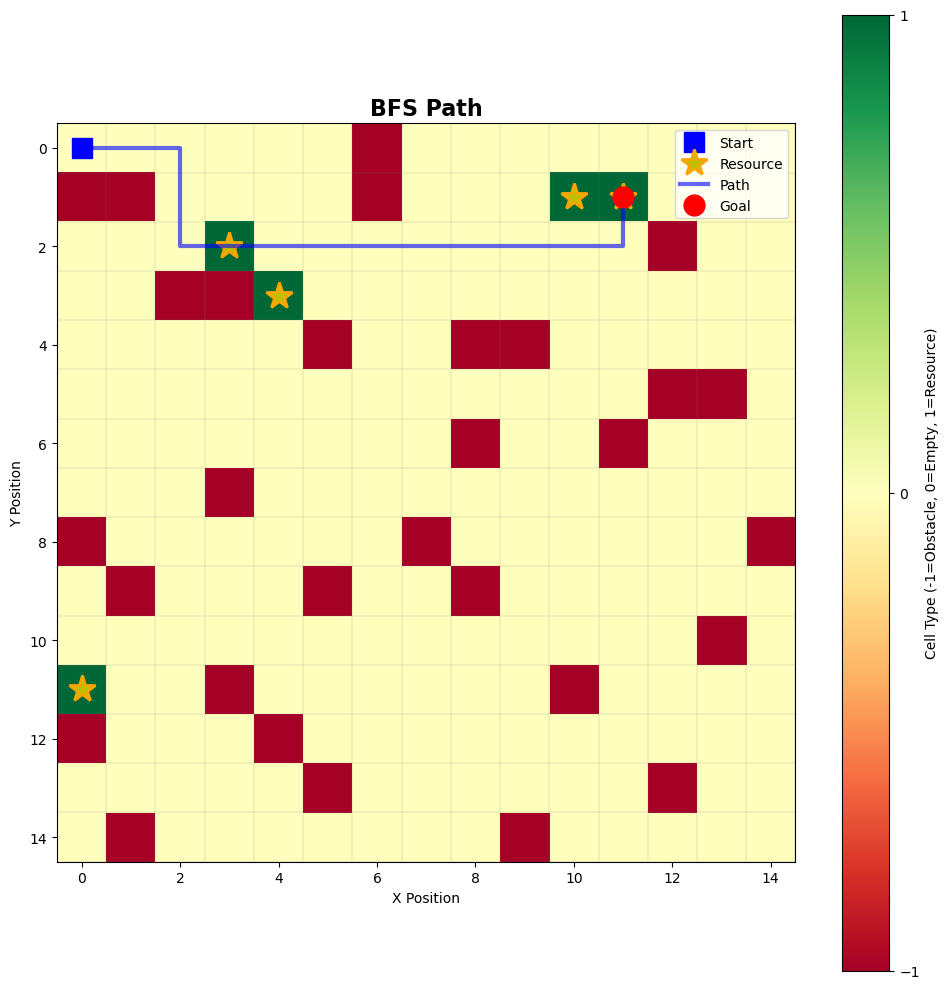

In [11]:
# Implement BFS and DFS

class SearchNode:
    """Node in the search tree."""
    def __init__(self, state: Tuple[int, int], parent=None, action=None, cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.cost = cost  # g(n): cost from start to this node
    
    def get_path(self) -> List[Tuple[int, int]]:
        """Reconstruct path from start to this node."""
        path = []
        node = self
        while node:
            path.append(node.state)
            node = node.parent
        return list(reversed(path))


def bfs(field: AsteroidField, start: Tuple[int, int], goal: Tuple[int, int]) -> Tuple[List[Tuple[int, int]], int]:
    """
    Breadth-First Search.
    
    Returns:
        (path, nodes_expanded)
    """
    if start == goal:
        return [start], 0
    
    frontier = deque([SearchNode(start)])
    explored = {start}
    nodes_expanded = 0
    
    while frontier:
        node = frontier.popleft()
        nodes_expanded += 1
        
        for neighbor in field.get_neighbors(*node.state):
            if neighbor not in explored:
                child = SearchNode(neighbor, parent=node, cost=node.cost + 1)
                
                if neighbor == goal:
                    return child.get_path(), nodes_expanded
                
                explored.add(neighbor)
                frontier.append(child)
    
    return None, nodes_expanded  # No solution


def dfs(field: AsteroidField, start: Tuple[int, int], goal: Tuple[int, int], max_depth: int = 100) -> Tuple[List[Tuple[int, int]], int]:
    """
    Depth-First Search (with depth limit to avoid infinite loops).
    
    Returns:
        (path, nodes_expanded)
    """
    if start == goal:
        return [start], 0
    
    frontier = [SearchNode(start)]  # Using list as stack
    explored = set()
    nodes_expanded = 0
    
    while frontier:
        node = frontier.pop()  # LIFO
        
        if node.state in explored:
            continue
        
        explored.add(node.state)
        nodes_expanded += 1
        
        if node.state == goal:
            return node.get_path(), nodes_expanded
        
        # Don't explore if at max depth
        if node.cost >= max_depth:
            continue
        
        # Add children in reverse order (so we explore in correct order when popping)
        for neighbor in reversed(field.get_neighbors(*node.state)):
            if neighbor not in explored:
                child = SearchNode(neighbor, parent=node, cost=node.cost + 1)
                frontier.append(child)
    
    return None, nodes_expanded  # No solution


# Test BFS and DFS
test_goal = list(field.resources)[0]  # Pick first resource as goal
print(f"Searching from (0, 0) to {test_goal}\\n")

# BFS
path_bfs, expanded_bfs = bfs(field, (0, 0), test_goal)
print(f"BFS: Found path of length {len(path_bfs)}, expanded {expanded_bfs} nodes")

# DFS
path_dfs, expanded_dfs = dfs(field, (0, 0), test_goal)
if path_dfs:
    print(f"DFS: Found path of length {len(path_dfs)}, expanded {expanded_dfs} nodes")
else:
    print(f"DFS: No solution found (expanded {expanded_dfs} nodes)")

# Visualize BFS result
field.visualize(path_bfs, "BFS Path")

## 4. Informed Search: A* Algorithm

**A* search** uses problem-specific knowledge (heuristics) to guide the search toward the goal more efficiently.

### The Evaluation Function
$$f(n) = g(n) + h(n)$$

where:
- $g(n)$ = **cost from start to node** $n$ (known, exact)
- $h(n)$ = **estimated cost from** $n$ **to goal** (heuristic)
- $f(n)$ = **estimated total cost** of path through $n$

A* always expands the node with the **lowest $f(n)$ value**.

### Heuristic Properties

**Admissible Heuristic**: Never overestimates the true cost to reach the goal
$$h(n) \leq h^*(n) \text{ for all } n$$
where $h^*(n)$ is the true optimal cost from $n$ to the goal.

**Consistent (Monotonic) Heuristic**: For every node $n$ and successor $n'$:
$$h(n) \leq c(n, n') + h(n')$$
where $c(n, n')$ is the cost of going from $n$ to $n'$.

**Important**: If $h(n)$ is consistent, it's also admissible, and A* is optimal!

### Manhattan Distance as a Heuristic
For grid-based navigation with 4-connected movement:
$$h(n) = |x_n - x_{goal}| + |y_n - y_{goal}|$$

This is **admissible** (never overestimates) and **consistent**.

Comparing search algorithms from (0, 0) to (11, 1)\n
A*:  Path length = 15, nodes expanded = 25
BFS: Path length = 15, nodes expanded = 72
\nA* efficiency: 2.88x fewer nodes expanded!


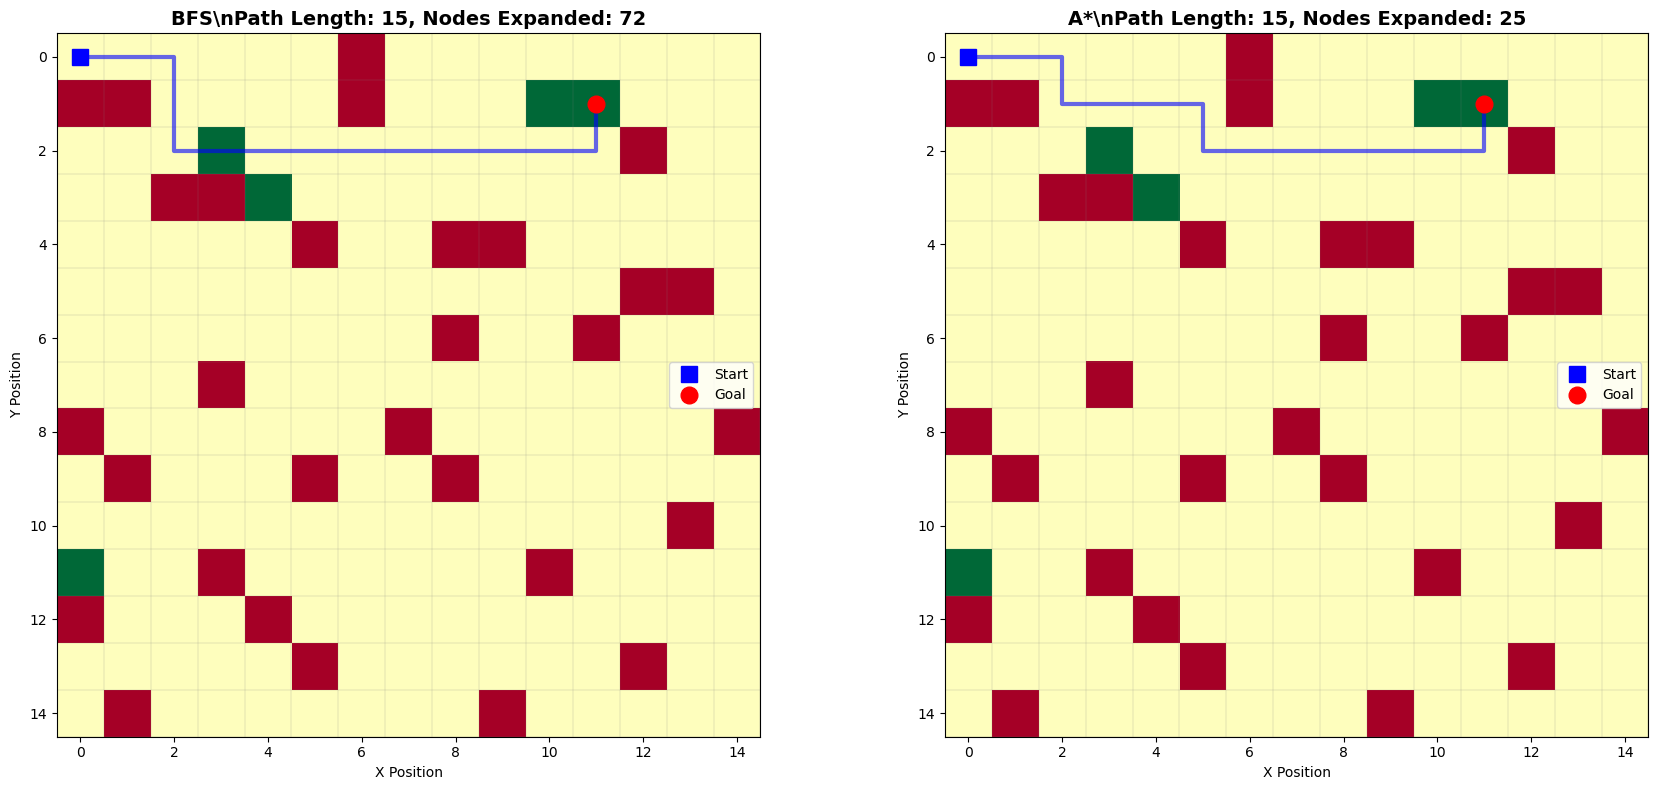

In [12]:
# Implement A* Search

class AStarNode:
    """Node for A* search with f(n) = g(n) + h(n)."""
    def __init__(self, state: Tuple[int, int], parent=None, g_cost=0, h_cost=0):
        self.state = state
        self.parent = parent
        self.g = g_cost  # Cost from start
        self.h = h_cost  # Heuristic estimate to goal
        self.f = g_cost + h_cost  # Total estimated cost
    
    def __lt__(self, other):
        """For priority queue comparison."""
        return self.f < other.f
    
    def get_path(self) -> List[Tuple[int, int]]:
        """Reconstruct path."""
        path = []
        node = self
        while node:
            path.append(node.state)
            node = node.parent
        return list(reversed(path))


def a_star(field: AsteroidField, start: Tuple[int, int], goal: Tuple[int, int]) -> Tuple[List[Tuple[int, int]], int, List]:
    """
    A* Search Algorithm.
    
    Returns:
        (path, nodes_expanded, expansion_order)
    """
    if start == goal:
        return [start], 0, [start]
    
    # Priority queue (min-heap)
    h_start = field.manhattan_distance(start, goal)
    frontier = [AStarNode(start, g_cost=0, h_cost=h_start)]
    heapq.heapify(frontier)
    
    # Track best cost to reach each state
    best_g = {start: 0}
    
    nodes_expanded = 0
    expansion_order = []
    
    while frontier:
        node = heapq.heappop(frontier)
        
        # Skip if we've found a better path to this state
        if node.g > best_g.get(node.state, float('inf')):
            continue
        
        expansion_order.append(node.state)
        nodes_expanded += 1
        
        if node.state == goal:
            return node.get_path(), nodes_expanded, expansion_order
        
        for neighbor in field.get_neighbors(*node.state):
            new_g = node.g + 1  # Cost of moving to neighbor
            
            # Only consider this path if it's better than any previous path
            if new_g < best_g.get(neighbor, float('inf')):
                best_g[neighbor] = new_g
                h = field.manhattan_distance(neighbor, goal)
                child = AStarNode(neighbor, parent=node, g_cost=new_g, h_cost=h)
                heapq.heappush(frontier, child)
    
    return None, nodes_expanded, expansion_order


# Compare A* with BFS
print(f"Comparing search algorithms from (0, 0) to {test_goal}\\n")

# A* Search
path_astar, expanded_astar, _ = a_star(field, (0, 0), test_goal)
print(f"A*:  Path length = {len(path_astar)}, nodes expanded = {expanded_astar}")
print(f"BFS: Path length = {len(path_bfs)}, nodes expanded = {expanded_bfs}")
print(f"\\nA* efficiency: {expanded_bfs / expanded_astar:.2f}x fewer nodes expanded!")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, path, title, expanded in [(axes[0], path_bfs, "BFS", expanded_bfs), 
                                     (axes[1], path_astar, "A*", expanded_astar)]:
    display_grid = np.copy(field.grid).astype(float)
    ax.imshow(display_grid, cmap='RdYlGn', interpolation='nearest', vmin=-1, vmax=1)
    
    # Grid lines
    for i in range(field.height + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.3, alpha=0.5)
    for j in range(field.width + 1):
        ax.axvline(j - 0.5, color='gray', linewidth=0.3, alpha=0.5)
    
    # Path
    if path:
        path_x = [p[0] for p in path]
        path_y = [p[1] for p in path]
        ax.plot(path_x, path_y, 'b-', linewidth=3, alpha=0.6)
        ax.plot(0, 0, 'bs', markersize=12, label='Start')
        ax.plot(path[-1][0], path[-1][1], 'ro', markersize=12, label='Goal')
    
    ax.set_title(f'{title}\\nPath Length: {len(path)}, Nodes Expanded: {expanded}', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.legend()

plt.tight_layout()
plt.show()

## 5. Constraint Satisfaction Problems (CSPs)

A **CSP** consists of:
- **Variables**: $X = \{X_1, X_2, ..., X_n\}$
- **Domains**: $D = \{D_1, D_2, ..., D_n\}$ where $D_i$ is the set of possible values for $X_i$
- **Constraints**: Rules that specify allowable combinations of values

### Factored Representation
Instead of enumerating all possible states, CSPs use a **factored representation**:
- Each variable can be assigned independently
- Constraints link variables together
- Much more compact than explicit state enumeration

### Drone Schedule CSP
Our drone must schedule daily operations:

**Variables**:
- `DrillTime`: Time spent drilling (minutes)
- `TravelTime`: Time spent traveling (minutes)
- `MaintenanceTime`: Time spent on maintenance (minutes)
- `FuelUsage`: Fuel consumed (units)

**Domains**:
- `DrillTime`: [0, 120]
- `TravelTime`: [0, 180]
- `MaintenanceTime`: [30, 60]
- `FuelUsage`: [0, 100]

**Constraints**:
1. Total time ≤ 480 minutes (8-hour workday)
2. FuelUsage = TravelTime × 0.5 + DrillTime × 0.3
3. FuelUsage ≤ 80 (fuel capacity)
4. DrillTime ≥ 60 (minimum drilling requirement)
5. MaintenanceTime ≥ 30 (safety requirement)

In [13]:
# Define the Drone Schedule CSP

class DroneScheduleCSP:
    """Constraint Satisfaction Problem for drone daily schedule."""
    
    def __init__(self):
        self.variables = ['DrillTime', 'TravelTime', 'MaintenanceTime', 'FuelUsage']
        self.domains = {
            'DrillTime': list(range(60, 121, 10)),  # 60-120, step 10
            'TravelTime': list(range(0, 181, 10)),  # 0-180, step 10
            'MaintenanceTime': list(range(30, 61, 10)),  # 30-60, step 10
            'FuelUsage': list(range(0, 101, 5))  # 0-100, step 5
        }
    
    def is_consistent(self, assignment: Dict[str, int]) -> bool:
        """Check if current assignment satisfies all constraints."""
        
        # Constraint 1: Total time ≤ 480 minutes
        if 'DrillTime' in assignment and 'TravelTime' in assignment and 'MaintenanceTime' in assignment:
            total_time = assignment['DrillTime'] + assignment['TravelTime'] + assignment['MaintenanceTime']
            if total_time > 480:
                return False
        
        # Constraint 2: FuelUsage = TravelTime × 0.5 + DrillTime × 0.3
        if 'FuelUsage' in assignment and 'TravelTime' in assignment and 'DrillTime' in assignment:
            required_fuel = assignment['TravelTime'] * 0.5 + assignment['DrillTime'] * 0.3
            if abs(assignment['FuelUsage'] - required_fuel) > 2:  # Allow small tolerance
                return False
        
        # Constraint 3: FuelUsage ≤ 80
        if 'FuelUsage' in assignment:
            if assignment['FuelUsage'] > 80:
                return False
        
        # Constraint 4: DrillTime ≥ 60
        if 'DrillTime' in assignment:
            if assignment['DrillTime'] < 60:
                return False
        
        # Constraint 5: MaintenanceTime ≥ 30
        if 'MaintenanceTime' in assignment:
            if assignment['MaintenanceTime'] < 30:
                return False
        
        return True
    
    def get_neighbors(self, var: str) -> List[str]:
        """Get variables that share constraints with var."""
        neighbors = {
            'DrillTime': ['TravelTime', 'MaintenanceTime', 'FuelUsage'],
            'TravelTime': ['DrillTime', 'MaintenanceTime', 'FuelUsage'],
            'MaintenanceTime': ['DrillTime', 'TravelTime'],
            'FuelUsage': ['DrillTime', 'TravelTime']
        }
        return neighbors.get(var, [])


# Create CSP instance
csp = DroneScheduleCSP()
print("Drone Schedule CSP created!")
print(f"Variables: {csp.variables}")
print(f"\\nDomain sizes:")
for var in csp.variables:
    print(f"  {var}: {len(csp.domains[var])} values")
    
# Test a valid assignment
test_assignment = {
    'DrillTime': 80,
    'TravelTime': 120,
    'MaintenanceTime': 40,
    'FuelUsage': 85  # Will fail constraint 3
}
print(f"\\nTest assignment: {test_assignment}")
print(f"Is consistent? {csp.is_consistent(test_assignment)}")

test_assignment['FuelUsage'] = 75
print(f"\\nAdjusted assignment: {test_assignment}")
print(f"Is consistent? {csp.is_consistent(test_assignment)}")

Drone Schedule CSP created!
Variables: ['DrillTime', 'TravelTime', 'MaintenanceTime', 'FuelUsage']
\nDomain sizes:
  DrillTime: 7 values
  TravelTime: 19 values
  MaintenanceTime: 4 values
  FuelUsage: 21 values
\nTest assignment: {'DrillTime': 80, 'TravelTime': 120, 'MaintenanceTime': 40, 'FuelUsage': 85}
Is consistent? False
\nAdjusted assignment: {'DrillTime': 80, 'TravelTime': 120, 'MaintenanceTime': 40, 'FuelUsage': 75}
Is consistent? False


## 6. Backtracking Search for CSPs

**Backtracking** is a depth-first search that:
1. Assigns one variable at a time
2. Checks constraints after each assignment
3. Backtracks when constraints are violated

**Algorithm**:
```
function BACKTRACKING-SEARCH(csp) returns solution or failure
    return BACKTRACK({}, csp)

function BACKTRACK(assignment, csp) returns solution or failure
    if assignment is complete then return assignment
    var ← SELECT-UNASSIGNED-VARIABLE(csp, assignment)
    for each value in ORDER-DOMAIN-VALUES(var, assignment, csp) do
        if value is consistent with assignment then
            add {var = value} to assignment
            result ← BACKTRACK(assignment, csp)
            if result ≠ failure then return result
            remove {var = value} from assignment
    return failure
```

### Improvements:
- **Minimum Remaining Values (MRV)**: Choose variable with fewest legal values
- **Degree Heuristic**: Choose variable involved in most constraints
- **Least Constraining Value**: Prefer values that rule out fewest choices for neighbors

In [14]:
# Implement Backtracking Search

def backtracking_search(csp: DroneScheduleCSP) -> Optional[Dict[str, int]]:
    """
    Backtracking search for CSP.
    
    Returns:
        Solution assignment or None if no solution exists
    """
    return backtrack({}, csp, 0)


def backtrack(assignment: Dict[str, int], csp: DroneScheduleCSP, depth: int) -> Optional[Dict[str, int]]:
    """Recursive backtracking."""
    
    # Check if assignment is complete
    if len(assignment) == len(csp.variables):
        return assignment
    
    # Select unassigned variable (using MRV heuristic)
    var = select_unassigned_variable(assignment, csp)
    
    # Try each value in domain
    for value in csp.domains[var]:
        assignment[var] = value
        
        # Check if consistent
        if csp.is_consistent(assignment):
            result = backtrack(assignment, csp, depth + 1)
            if result is not None:
                return result
        
        # Remove assignment (backtrack)
        del assignment[var]
    
    return None


def select_unassigned_variable(assignment: Dict[str, int], csp: DroneScheduleCSP) -> str:
    """Select next variable using Minimum Remaining Values (MRV) heuristic."""
    unassigned = [v for v in csp.variables if v not in assignment]
    
    # Simple version: just pick first unassigned
    # Could be improved with MRV heuristic
    return unassigned[0]


# Solve the CSP
print("Solving Drone Schedule CSP with backtracking...\\n")
solution = backtracking_search(csp)

if solution:
    print("Solution found!")
    for var, value in solution.items():
        print(f"  {var}: {value}")
    
    # Verify solution
    total_time = solution['DrillTime'] + solution['TravelTime'] + solution['MaintenanceTime']
    fuel_calc = solution['TravelTime'] * 0.5 + solution['DrillTime'] * 0.3
    
    print(f"\\nVerification:")
    print(f"  Total time: {total_time}/480 minutes")
    print(f"  Fuel usage: {solution['FuelUsage']}/80 units (calculated: {fuel_calc:.1f})")
else:
    print("No solution found!")

Solving Drone Schedule CSP with backtracking...\n
Solution found!
  DrillTime: 60
  TravelTime: 0
  MaintenanceTime: 30
  FuelUsage: 20
\nVerification:
  Total time: 90/480 minutes
  Fuel usage: 20/80 units (calculated: 18.0)


## 7. Arc Consistency and AC-3 Algorithm

**Arc Consistency**: A variable $X_i$ is arc-consistent with respect to $X_j$ if for every value in $D_i$, there exists a value in $D_j$ that satisfies the constraint between them.

**AC-3 Algorithm**: Makes the entire CSP arc-consistent by iteratively enforcing arc consistency.

**Algorithm**:
```
function AC-3(csp) returns false if inconsistency found, true otherwise
    queue ← all arcs in csp
    while queue is not empty do
        (Xi, Xj) ← REMOVE-FIRST(queue)
        if REVISE(csp, Xi, Xj) then
            if Di is empty then return false
            for each Xk in NEIGHBORS(Xi) except Xj do
                add (Xk, Xi) to queue
    return true

function REVISE(csp, Xi, Xj) returns true iff domain of Xi was revised
    revised ← false
    for each x in Di do
        if no value y in Dj satisfies constraint(Xi=x, Xj=y) then
            delete x from Di
            revised ← true
    return revised
```

**Key Benefit**: Reduces domain sizes before search, making backtracking more efficient!

**Complexity**: $O(cd^3)$ where $c$ is number of arcs and $d$ is domain size.

## 8. Local Search: Min-Conflicts Algorithm

**Local Search** for CSPs starts with a complete (but possibly inconsistent) assignment and iteratively improves it.

**Min-Conflicts Algorithm**:
1. Start with a complete assignment (possibly violating constraints)
2. Repeat until solution found or max steps reached:
   - Select a variable involved in a constraint violation
   - Choose the value that minimizes the number of conflicts with other variables

**Advantages**:
- Very fast for many practical problems
- Can handle very large CSPs
- Good for repair/rescheduling problems

**Algorithm**:
```
function MIN-CONFLICTS(csp, max_steps) returns solution or failure
    current ← an initial complete assignment for csp
    for i = 1 to max_steps do
        if current is a solution for csp then return current
        var ← a randomly chosen conflicted variable from csp
        value ← the value v for var that minimizes CONFLICTS(var, v, current, csp)
        set var = value in current
    return failure
```

**Perfect for**: Quickly repairing drone schedules when new tasks are added!

In [15]:
# Implement Min-Conflicts

def min_conflicts(csp: DroneScheduleCSP, max_steps: int = 1000) -> Optional[Dict[str, int]]:
    """
    Min-conflicts local search for CSP.
    
    Returns:
        Solution assignment or None if no solution found
    """
    # Start with random complete assignment
    current = {var: random.choice(csp.domains[var]) for var in csp.variables}
    
    for step in range(max_steps):
        # Check if solution found
        if csp.is_consistent(current):
            return current
        
        # Find conflicted variables
        conflicted = get_conflicted_variables(current, csp)
        if not conflicted:
            return current
        
        # Choose random conflicted variable
        var = random.choice(conflicted)
        
        # Find value that minimizes conflicts
        best_value = min(csp.domains[var], 
                        key=lambda v: count_conflicts({**current, var: v}, csp))
        current[var] = best_value
    
    return None  # Failed to find solution


def get_conflicted_variables(assignment: Dict[str, int], csp: DroneScheduleCSP) -> List[str]:
    """Get list of variables involved in constraint violations."""
    conflicted = []
    
    # Check each constraint
    total_time = assignment['DrillTime'] + assignment['TravelTime'] + assignment['MaintenanceTime']
    if total_time > 480:
        conflicted.extend(['DrillTime', 'TravelTime', 'MaintenanceTime'])
    
    required_fuel = assignment['TravelTime'] * 0.5 + assignment['DrillTime'] * 0.3
    if abs(assignment['FuelUsage'] - required_fuel) > 2:
        conflicted.extend(['FuelUsage', 'TravelTime', 'DrillTime'])
    
    if assignment['FuelUsage'] > 80:
        conflicted.append('FuelUsage')
    
    return list(set(conflicted))  # Remove duplicates


def count_conflicts(assignment: Dict[str, int], csp: DroneScheduleCSP) -> int:
    """Count number of constraint violations."""
    conflicts = 0
    
    total_time = assignment['DrillTime'] + assignment['TravelTime'] + assignment['MaintenanceTime']
    if total_time > 480:
        conflicts += 1
    
    required_fuel = assignment['TravelTime'] * 0.5 + assignment['DrillTime'] * 0.3
    if abs(assignment['FuelUsage'] - required_fuel) > 2:
        conflicts += 1
    
    if assignment['FuelUsage'] > 80:
        conflicts += 1
    
    if assignment['DrillTime'] < 60:
        conflicts += 1
    
    if assignment['MaintenanceTime'] < 30:
        conflicts += 1
    
    return conflicts


# Test min-conflicts
print("Solving Drone Schedule CSP with min-conflicts...\\n")
random.seed(42)
solution_mc = min_conflicts(csp, max_steps=1000)

if solution_mc:
    print("Solution found!")
    for var, value in solution_mc.items():
        print(f"  {var}: {value}")
    
    # Verify
    total_time = solution_mc['DrillTime'] + solution_mc['TravelTime'] + solution_mc['MaintenanceTime']
    fuel_calc = solution_mc['TravelTime'] * 0.5 + solution_mc['DrillTime'] * 0.3
    
    print(f"\\nVerification:")
    print(f"  Total time: {total_time}/480 minutes")
    print(f"  Fuel usage: {solution_mc['FuelUsage']}/80 units (calculated: {fuel_calc:.1f})")
    print(f"  Conflicts: {count_conflicts(solution_mc, csp)}")
else:
    print("No solution found!")

Solving Drone Schedule CSP with min-conflicts...\n
Solution found!
  DrillTime: 110
  TravelTime: 10
  MaintenanceTime: 30
  FuelUsage: 40
\nVerification:
  Total time: 150/480 minutes
  Fuel usage: 40/80 units (calculated: 38.0)
  Conflicts: 0


## 9. Animated A* Visualization

Let's create an animated visualization showing how A* explores the state space!

In [16]:
# Animated A* Search Visualization

def animate_astar_search(field: AsteroidField, start: Tuple[int, int], goal: Tuple[int, int]):
    """Create animation showing A* search progress."""
    
    # Run A* to get expansion order
    path, nodes_expanded, expansion_order = a_star(field, start, goal)
    
    # Create animation
    fig, ax = plt.subplots(figsize=(10, 10))
    
    def init():
        ax.clear()
        return []
    
    def animate(frame):
        ax.clear()
        
        # Draw grid
        display_grid = np.copy(field.grid).astype(float)
        ax.imshow(display_grid, cmap='RdYlGn', interpolation='nearest', vmin=-1, vmax=1)
        
        # Grid lines
        for i in range(field.height + 1):
            ax.axhline(i - 0.5, color='gray', linewidth=0.3, alpha=0.5)
        for j in range(field.width + 1):
            ax.axvline(j - 0.5, color='gray', linewidth=0.3, alpha=0.5)
        
        # Show explored nodes up to current frame
        for i in range(min(frame + 1, len(expansion_order))):
            x, y = expansion_order[i]
            alpha = 0.3 + 0.4 * (i / max(1, len(expansion_order)))
            ax.plot(x, y, 'o', color='cyan', markersize=8, alpha=alpha)
        
        # Draw start and goal
        ax.plot(start[0], start[1], 'bs', markersize=15, label='Start')
        ax.plot(goal[0], goal[1], 'r*', markersize=20, markeredgecolor='orange', 
               markeredgewidth=2, label='Goal')
        
        # Draw path if search is complete
        if frame >= len(expansion_order) and path:
            path_x = [p[0] for p in path]
            path_y = [p[1] for p in path]
            ax.plot(path_x, path_y, 'b-', linewidth=3, alpha=0.6, label='Path')
        
        ax.set_title(f'A* Search Progress\\nNodes Expanded: {min(frame + 1, len(expansion_order))}/{len(expansion_order)}', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.legend()
        
        return []
    
    anim = FuncAnimation(fig, animate, init_func=init, 
                        frames=len(expansion_order) + 10, 
                        interval=100, blit=True, repeat=True)
    
    plt.close()
    return anim


# Create animation
print("Creating A* search animation...")
animation = animate_astar_search(field, (0, 0), test_goal)
HTML(animation.to_jshtml())

Creating A* search animation...


## 10. Exercises

### Exercise 1: Heuristic Analysis
Prove that the Manhattan distance heuristic is admissible for our grid-based navigation problem. Hint: Consider the minimum number of moves needed.

### Exercise 2: Implement Euclidean Distance Heuristic
Implement an alternative heuristic using Euclidean distance:
$$h(n) = \sqrt{(x_n - x_{goal})^2 + (y_n - y_{goal})^2}$$

Is this heuristic admissible for 4-connected grid movement? Why or why not?

### Exercise 3: Modify the CSP
Add a new constraint to the Drone Schedule CSP: "If DrillTime > 90, then MaintenanceTime must be at least 45". Implement this constraint and solve the modified CSP.

### Exercise 4: Compare Search Algorithms
Run BFS, DFS, and A* on multiple different start-goal pairs in the asteroid field. Create a table comparing:
- Path length found
- Number of nodes expanded
- Time taken

What patterns do you observe?

In [ ]:
# Exercise 2: Implement Euclidean Distance Heuristic

def euclidean_distance(pos1: Tuple[int, int], pos2: Tuple[int, int]) -> float:
    """
    Calculate Euclidean distance between two positions.
    TODO: Implement this function
    """
    # Your code here
    pass


def a_star_euclidean(field: AsteroidField, start: Tuple[int, int], goal: Tuple[int, int]):
    """
    A* with Euclidean distance heuristic.
    TODO: Modify the a_star function to use euclidean_distance instead of manhattan_distance
    """
    # Your code here
    pass


# Test your implementation
# path_euclidean, expanded_euclidean, _ = a_star_euclidean(field, (0, 0), test_goal)
# print(f"A* (Euclidean): Path length = {len(path_euclidean)}, nodes expanded = {expanded_euclidean}")
# print(f"A* (Manhattan):  Path length = {len(path_astar)}, nodes expanded = {expanded_astar}")

## 11. Key Concepts Summary

### State-Space Search
- **Abstraction**: Simplify the problem by removing irrelevant details
- **State-space graph**: Nodes = states, edges = actions
- **Goal**: Find lowest-cost path from initial state to goal state

### Search Algorithms
| Algorithm | Complete | Optimal | Time | Space | Uses Heuristic |
|-----------|----------|---------|------|-------|----------------|
| **BFS** | Yes | Yes* | $O(b^d)$ | $O(b^d)$ | No |
| **DFS** | No | No | $O(b^m)$ | $O(bm)$ | No |
| **A*** | Yes | Yes** | $O(b^d)$ | $O(b^d)$ | Yes |

\* For uniform cost  
\*\* If heuristic is admissible

### A* Evaluation Function
$$f(n) = g(n) + h(n)$$
- $g(n)$: Actual cost from start to $n$
- $h(n)$: Estimated cost from $n$ to goal (heuristic)
- Admissible heuristic: $h(n) \leq h^*(n)$ (never overestimates)
- Consistent heuristic: $h(n) \leq c(n,n') + h(n')$

### Constraint Satisfaction Problems
- **Variables**: What we're trying to assign values to
- **Domains**: Possible values for each variable
- **Constraints**: Rules that restrict value combinations

### CSP Algorithms
- **Backtracking**: DFS with constraint checking
- **AC-3**: Enforce arc consistency to reduce domains
- **Min-conflicts**: Local search for rapid solutions/repairs

## 12. Looking Ahead: Module 3

### Module 3 Preview: Adversarial Search and Game Playing

In the next module, our drone faces competition:
- **New environment**: Rival corporations enter the asteroid field
- **Zero-sum games**: One agent's gain is another's loss
- **New algorithms**: Minimax, Alpha-Beta pruning
- **Stochastic elements**: Expected value calculations with chance nodes
- **Horizon effect**: Dealing with search depth limitations

The cooperative problem-solving of Module 2 gives way to **adversarial reasoning**—the drone must now anticipate and counter opponent moves!

### The Journey Ahead
- Module 4: Logical reasoning with First-Order Logic and Prolog
- Module 5: Probabilistic reasoning with Bayesian networks
- Module 6: Decision theory and utility maximization
- Module 7: Machine learning from experience

## 13. References and Further Reading

### Primary Textbook
- Russell, S. J., & Norvig, P. (2020). *Artificial Intelligence: A Modern Approach* (4th ed.). Pearson.
  - Chapter 3: Solving Problems by Searching (Sections 3.1, 3.2, 3.4, 3.5.2)
  - Chapter 6: Constraint Satisfaction Problems (Sections 6.1, 6.2, 6.3, 6.4)

### Key Sections Referenced
- **[3.1, 3.2]** State-space graphs and abstraction
- **[3.4]** Asymptotic complexity and algorithm analysis
- **[3.5.2]** A* search algorithm and evaluation functions
- **[6.1]** CSPs: Variables, domains, and constraints
- **[6.2, 6.2.2]** Constraint propagation and arc consistency (AC-3)
- **[6.3]** Backtracking search for CSPs
- **[6.4]** Local search: Min-conflicts algorithm

### Additional Resources
- Cormen, T. H., et al. (2009). *Introduction to Algorithms* (3rd ed.). MIT Press.
- Dechter, R. (2003). *Constraint Processing*. Morgan Kaufmann.

### Classic Papers
- Hart, P. E., Nilsson, N. J., & Raphael, B. (1968). "A Formal Basis for the Heuristic Determination of Minimum Cost Paths." *IEEE Transactions on Systems Science and Cybernetics*, 4(2), 100-107.
- Mackworth, A. K. (1977). "Consistency in Networks of Relations." *Artificial Intelligence*, 8(1), 99-118.

---

**Congratulations!** You've completed Module 2: Problem Solving, Search, and Constraint Satisfaction. You can now build agents that plan optimal paths through complex environments and satisfy multiple operational constraints simultaneously!